In [94]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

In [102]:
file_names = ['seg_data1.csv', 'seg_data2.csv', 'seg_data3.csv', 'seg_data4.csv', 'seg_data5.csv', 'seg_data6.csv', 'seg_data7.csv'] # Create list of CSV file names

In [103]:
df = pd.concat((pd.read_csv(i) for i in file_names)).reset_index(drop = True) # Import
print(df)     

        SegmentId        StartTime        Start          EndTime       Speed
0      1071707139    7/5/2021 0:00  44382.00000    7/5/2021 0:30  116.200000
1      1071707139    7/5/2021 0:30  44382.02083    7/5/2021 1:00   99.966667
2      1071707139    7/5/2021 1:00  44382.04167    7/5/2021 1:30  114.266667
3      1071707139    7/5/2021 1:30  44382.06250    7/5/2021 2:00   98.000000
4      1071707139    7/5/2021 2:00  44382.08333    7/5/2021 2:30   99.466667
...           ...              ...          ...              ...         ...
66187  1071729662  7/11/2021 21:30  44388.89583  7/11/2021 22:00  107.400000
66188  1071729662  7/11/2021 22:00  44388.91667  7/11/2021 22:30   98.966667
66189  1071729662  7/11/2021 22:30  44388.93750  7/11/2021 23:00  102.466667
66190  1071729662  7/11/2021 23:00  44388.95833  7/11/2021 23:30  101.600000
66191  1071729662  7/11/2021 23:30  44388.97917  7/11/2021 23:59   87.000000

[66192 rows x 5 columns]


In [104]:
df.head(4)

,SegmentId,StartTime,Start,EndTime,Speed
0,1071707139,7/5/2021 0:00,44382.00000,7/5/2021 0:30,116.200000
1,1071707139,7/5/2021 0:30,44382.02083,7/5/2021 1:00,99.966667
2,1071707139,7/5/2021 1:00,44382.04167,7/5/2021 1:30,114.266667
3,1071707139,7/5/2021 1:30,44382.06250,7/5/2021 2:00,98.000000


In [105]:
df.drop(columns  = [ 'EndTime','StartTime'], inplace = True)

In [106]:
df_reset=df.set_index('Start')
len(df.index)

66192

In [107]:
df.head(4)

,SegmentId,Start,Speed
0,1071707139,44382.00000,116.200000
1,1071707139,44382.02083,99.966667
2,1071707139,44382.04167,114.266667
3,1071707139,44382.06250,98.000000


In [108]:
values = df.values
# ensure all data is float
values = values.astype('float32')

In [109]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [110]:
scaled.head(4)

,0,1,2
0,0.999782,0.000000,0.830315
1,0.999782,0.002930,0.675564
2,0.999782,0.006348,0.811884
3,0.999782,0.008789,0.656816


In [111]:
def create_ts_data(df, lookback=1, predicted_col=2):
    temp=df.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=df.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [112]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,2)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)','var4(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)
id                                            
1    0.999782   0.000000   0.830315   0.675564
2    0.999782   0.002930   0.675564   0.811884
3    0.999782   0.006348   0.811884   0.656816
4    0.999782   0.008789   0.656816   0.670798


In [113]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(df) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [114]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(46334, 1, 3) (46334,) (19857, 1, 3) (19857,)


In [115]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 100)            41600     
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 30)             15720     
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 64,671
Trainable params: 64,671
Non-trainable params: 0
_________________________________________________________________


In [116]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=80,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/80
724/724 [==============================] - 8s 5ms/step - loss: 0.1870 - val_loss: 0.0546
Epoch 2/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0569 - val_loss: 0.0541
Epoch 3/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0557 - val_loss: 0.0523
Epoch 4/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0550 - val_loss: 0.0524
Epoch 5/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0546 - val_loss: 0.0520
Epoch 6/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0540 - val_loss: 0.0510
Epoch 7/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0530 - val_loss: 0.0512
Epoch 8/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0521 - val_loss: 0.0507
Epoch 9/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0519 - val_loss: 0.0509
Epoch 10/80
724/724 [==============================] - 2s 3ms/step - loss: 0.0517 - val_loss: 0.0513

In [117]:
pred_y =  model_lstm.predict(test_X)

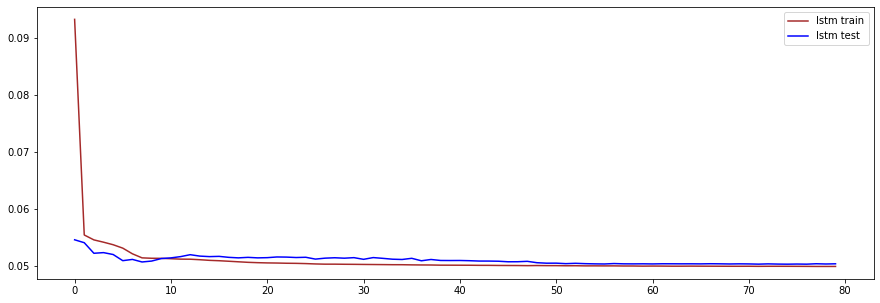

In [118]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [120]:
test_y.reshape(19857,1)

array([[0.63552594],
       [0.64855415],
       [0.76008904],
       ...,
       [0.69939625],
       [0.6911344 ],
       [0.55195427]], dtype=float32)

In [121]:
pred_y

array([[0.68089944],
       [0.6721003 ],
       [0.67635834],
       ...,
       [0.69301116],
       [0.7028481 ],
       [0.7006428 ]], dtype=float32)

0.004343393
0.48742158452891915
0.06590442165051713
0.05040993


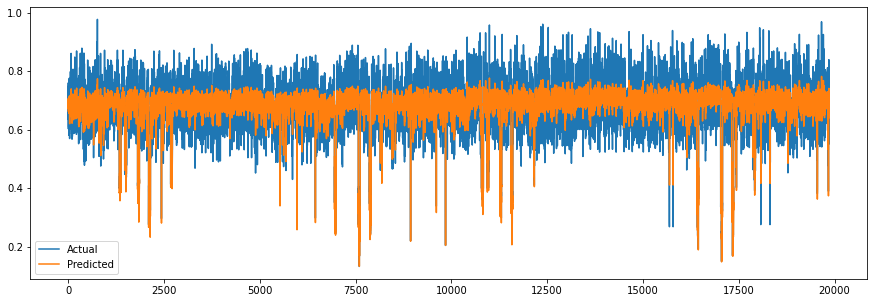

In [122]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

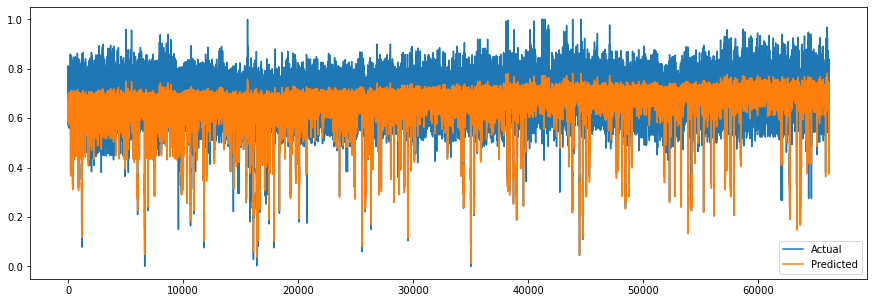

In [123]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

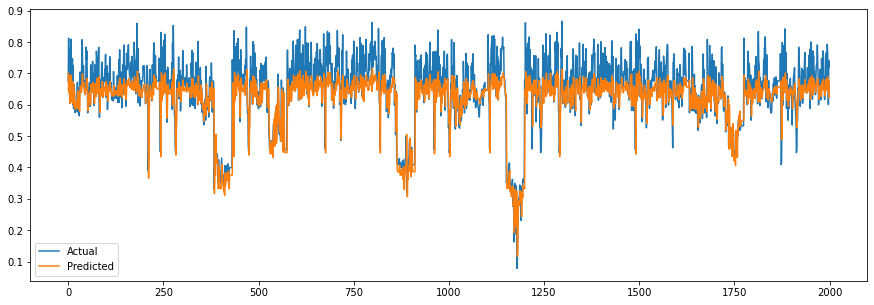

In [124]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()